In [1]:
import astropy as ast
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GeocentricTrueEcliptic, get_body, SkyCoord
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
register_matplotlib_converters()

## Data Wrangling

This code handles data generation (if needed) and otherwise prepares data for prediction by loading from `.csv` files. Basic visualization is also done here.

In [2]:
GENERATE_DATA = False # set GENERATE_DATA to True to generate data again. May take ~1h or more depending on processing power

In [3]:
if GENERATE_DATA:
    data = pd.read_csv('solar_eclipse_data.csv')

    # Select for years between 1900AD and 2100AD (to maintain accuracy of astropy data)
    years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 1900 and int(x) <= 2050)
    data = data[years_to_keep]

    # Convert to ISO dates
    data['Datetime'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data['ISO Date'] = data['Datetime'].apply(lambda x: x.isoformat())
    data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))
    data.head()

In [4]:
# All of the celestial bodies to generate synthetic data for
BODY_NAMES = ['moon', 'sun']

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
LOCATION = EarthLocation.of_site('medicina')

In [5]:
def convert_latitude(latitude):
    if latitude[-1] == 'N':
        return float(latitude[:-1])
    elif latitude[-1] == 'S':
        return -float(latitude[:-1])
    else:
        raise ValueError
        
def convert_longitude(longitude):
    if longitude[-1] == 'E':
        return float(longitude[:-1])
    elif longitude[-1] == 'W':
        return -float(longitude[:-1])
    else:
        raise ValueError

def get_coordinates(body):
    # Takes a Skycoord object, returns (theta, phi) in (deg, deg)
    angles = [float(i) for i in body.to_string().split(' ')]
    
    phi = angles[0]
    theta = angles[1]
    return phi, theta

def get_coordinate_rows(times):
    rows = defaultdict(list)
    for time in times:
        print(time)
        bodies = []

        with solar_system_ephemeris.set('builtin'):
            for body_name in BODY_NAMES:
                bodies.append(get_body(body_name, time, LOCATION))

        rows['time'].append(time)
        rows['location'].append(str(LOCATION))

        for body_name, body in zip(BODY_NAMES, bodies):
            theta, phi = get_coordinates(body)
            ecliptic = SkyCoord(theta, phi, frame='gcrs', unit=('deg', 'deg')).transform_to(GeocentricTrueEcliptic())
            coordinates = get_coordinates(ecliptic)
            coord_strings = ['theta', 'phi']

            for i in range(len(coord_strings)):
                c = coordinates[i]
                rows[body_name + '_' + coord_strings[i]].append(c)
    return rows

In [6]:
if GENERATE_DATA:
    times = data['ISO Date']
    rows = get_coordinate_rows(times)
    for k in rows.keys():
        data[k] = rows[k]

    data['latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
    data['longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
    data = data[['ISO Date', 'longitude', 'latitude', 'moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
    data['eclipse'] = 1
    data.to_csv('solar_eclipse_pos_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [7]:
if GENERATE_DATA:
    # Generate the negative samples, i.e. times at which an eclipse is not occuring
    times = []
    for i in range(1, len(data)):
        # Difference in days
        days_difference = data['ISO Date'][i] - data['ISO Date'][i - 1]
        offset = 1
        # Enforce that datapoints in the non-eclipse class are sufficiently distant from datapoints in the eclipse class
        while offset < days_difference - 1:
            offset += abs(np.random.normal(5, 2))
            time = data['ISO Date'][i - 1] + offset
            times.append(time)

    rows = get_coordinate_rows(times)

    negative_data = pd.DataFrame(rows)
    negative_data['eclipse'] = 0
    negative_data.rename(columns={'time':'ISO Date'}, inplace=True)
    negative_data = negative_data.drop(columns='location')
    negative_data.to_csv('solar_eclipse_neg_data.csv', index=False)
else:
    negative_data = pd.read_csv('solar_eclipse_neg_data.csv')
negative_data['ISO Date'] = negative_data['ISO Date'].apply(lambda x: Time(x))

In [8]:
if GENERATE_DATA:
    data = data.drop(columns=['longitude', 'latitude']) # Drop the longitude and latitude from the positive dataset, as they are undefined for the negative dataset
    data = pd.concat([data, negative_data], sort=True)
    data.to_csv('solar_eclipse_final_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_final_data.csv')
data = data.sort_values('ISO Date')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [9]:
# Plot to understand the data
def plot_parameter(param, n):
    positive = data[data['eclipse'] == 1]
    negative = data[data['eclipse'] == 0]
    
    fig, ax = plt.subplots()
    dates = [pd.to_datetime(d.value.split('T')[0]) for d in positive['ISO Date'][:n]]
    pos = plt.plot_date(dates, positive[param][:n], label='eclipse=1')
    dates = [pd.to_datetime(d.value.split('T')[0]) for d in negative['ISO Date'][:n]]
    neg = plt.plot_date(dates, negative[param][:n], label='eclipse=0')
    date_form = DateFormatter("%Y-%m-%d")
    ax.set_title('%s vs. date' % param)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(date_form)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=120))
    plt.legend()
    plt.show()

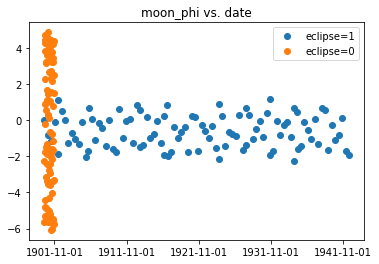

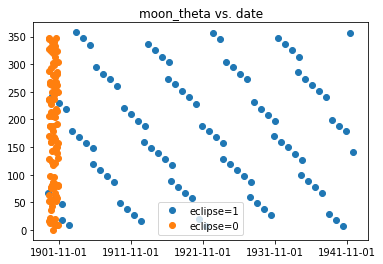

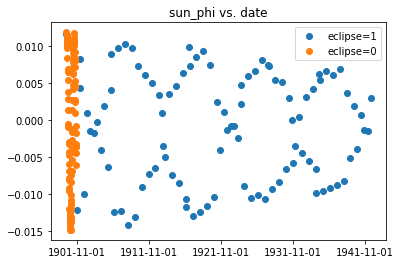

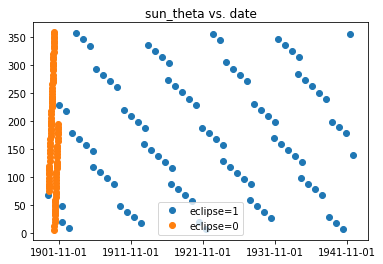

In [10]:
plot_parameter('moon_phi', 100)
plot_parameter('moon_theta', 100)
plot_parameter('sun_phi', 100)
plot_parameter('sun_theta', 100)

## Eclipse Incidence Prediction

This code handles model initialization, training and prediction to answer: "given a time and the position of the moon and sun, is an eclipse occuring?"

In [11]:
X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data['eclipse'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", # "Gaussian Process", removing due to long runtime
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [KNeighborsClassifier(3),
    SVC(kernel="sigmoid", C=0.025),
    SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)), removing due to long runtime
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


classifiers = dict(zip(names, classifiers))

Nearest Neighbors
Train score: 0.9694146020609515
Test score: 0.9706269180184129
Linear SVM
Train score: 0.9700723525542644
Test score: 0.9706269180184129
RBF SVM
Train score: 0.9986844990133743
Test score: 0.9706269180184129
Decision Tree
Train score: 0.9712782284586713
Test score: 0.9701885138097326
Random Forest
Train score: 0.9705108528831397
Test score: 0.9706269180184129
Neural Net
Train score: 0.9700723525542644
Test score: 0.9706269180184129
AdaBoost
Train score: 0.9707301030475772
Test score: 0.9679964927663306
Naive Bayes
Train score: 0.9700723525542644
Test score: 0.9706269180184129
QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


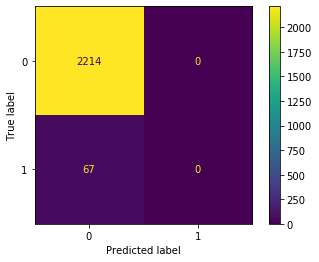

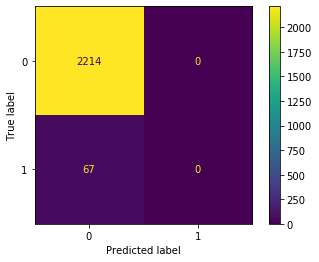

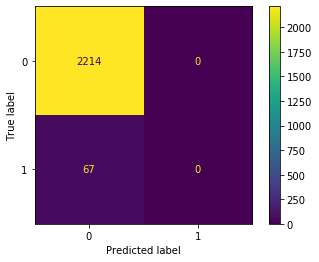

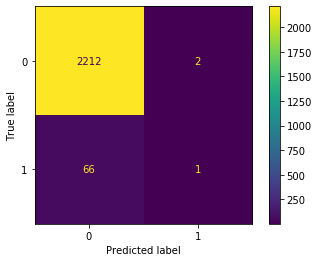

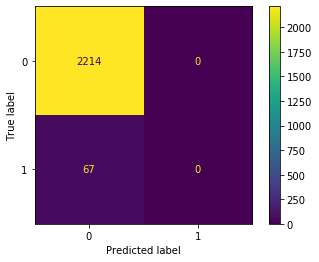

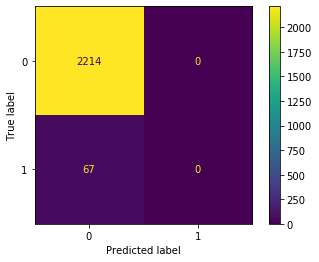

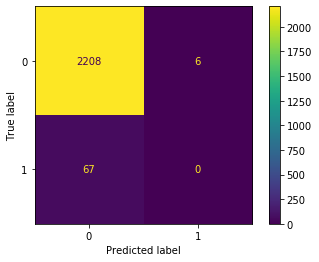

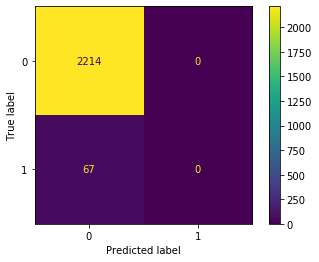

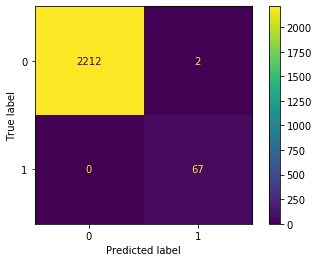

In [17]:
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    plot_confusion_matrix(clf, X_test, y_test)
    print(name)
    print('Train score:', clf.score(X_train, y_train))
    print('Test score:', clf.score(X_test, y_test))

QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


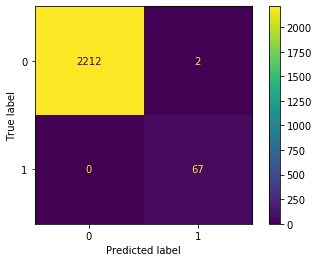

In [22]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('QDA')
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))

In [24]:
from sklearn.model_selection import GridSearchCV

QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


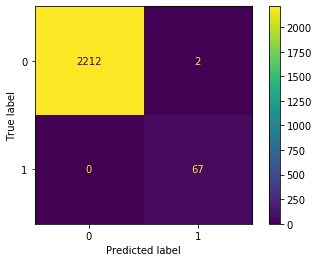

In [25]:
params = [{'reg_param': np.arange(0, 0.00001, 0.000001)}]
qda = QuadraticDiscriminantAnalysis()
clf = GridSearchCV(qda, params)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('QDA')
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))

In [26]:
clf.best_params_['reg_param']

1e-06

In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, clf.predict(X_test))

0.9852941176470589

## Eclipse Location Prediction

This code handles model initialization, training and prediction to answer: "given a time that an eclipse is occuring, the position of the moon, the position of the sun, where on Earth is the eclipse visible?"

Still work in progress!

In [214]:
data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data[['longitude']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0., shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [262]:
X

array([[ 6.75568000e+01,  7.68181000e-03,  6.81689000e+01,
         1.15626000e-02,  2.41516812e+06],
       [ 2.41644000e+02, -8.17203000e-01,  2.40937000e+02,
        -1.34169000e-02,  2.41534581e+06],
       [ 5.84661000e+01, -1.15428000e+00,  5.79427000e+01,
         9.68140000e-03,  2.41552273e+06],
       ...,
       [ 2.43465000e+02, -2.37014000e-01,  2.42677000e+02,
         4.83325000e-03,  2.46977073e+06],
       [ 5.86778000e+01, -1.54391000e+00,  5.93220000e+01,
        -7.74589000e-03,  2.46994736e+06],
       [ 2.31367000e+02,  1.12373000e-01,  2.31651000e+02,
         3.56873000e-03,  2.47012506e+06]])

In [272]:
X

,moon_theta,moon_phi,sun_theta,sun_phi,0
0,67.5568,0.007682,68.1689,0.011563,2.415168e+06
1,241.6440,-0.817203,240.9370,-0.013417,2.415346e+06
2,58.4661,-1.154280,57.9427,0.009681,2.415523e+06
3,230.2360,-0.132481,229.5880,-0.012132,2.415700e+06
4,18.6202,1.111810,19.1625,0.004258,2.415848e+06
...,...,...,...,...,...
335,252.9560,-1.231850,253.4840,0.004103,2.469416e+06
336,69.3657,-0.464205,69.8649,-0.007202,2.469593e+06
337,243.4650,-0.237014,242.6770,0.004833,2.469771e+06
338,58.6778,-1.543910,59.3220,-0.007746,2.469947e+06


In [273]:
data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

X = data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
X = pd.concat([X, pd.DataFrame([[d.jd] for d in data['ISO Date']])], axis=1)
y = data[['longitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

Score: 0.6013842973761816


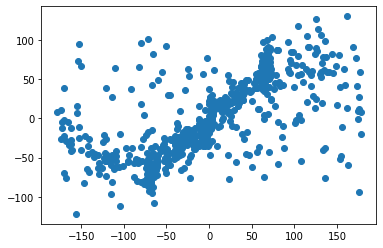

In [231]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=10)
X_train_aug = poly.fit_transform(X_train)

reg = LinearRegression().fit(X_train_aug, convert_Y(y_train))
print('Score:', reg.score(X_train_aug, convert_Y(y_train)))

pred = reg.predict(X_train_aug)
plt.scatter(y_train, pred)
plt.show()

Score: 0.5416874236704003


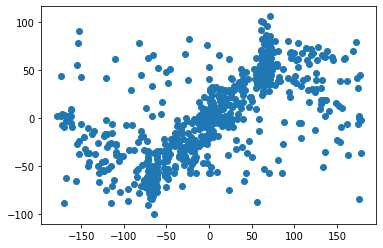

In [244]:
reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)
print('Score:', reg.score(X_train, y_train))

pred = reg.predict(X_train)
plt.scatter(y_train, pred)
plt.show()

Score: 0.9020641201910122


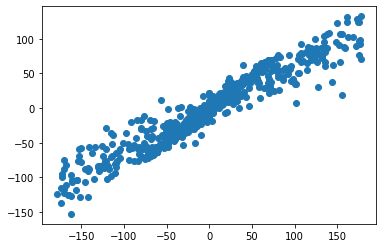

In [228]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=50)
reg.fit(X_train, y_train)
print('Score:', reg.score(X_train, y_train))
pred = reg.predict(X_train)
plt.scatter(y_train, pred)
plt.show()

In [229]:
reg.score(X_test, y_test)

0.31207146559834875

Score: 0.19281130851788486


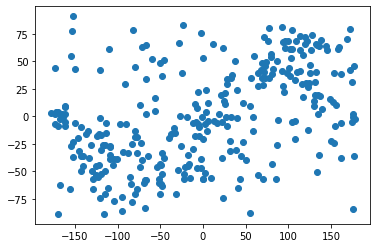

In [210]:
from sklearn.linear_model import RidgeCV, LinearRegression, Lasso, SGDRegressor
reg = RidgeCV(alphas=np.arange(0.1,100,0.1), fit_intercept=True)
reg.fit(X_train, y_train)
print('Score:', reg.score(X_train, y_train))
pred = reg.predict(X_train)
plt.scatter(y_train, pred)
plt.show()

Score: 0.0042306317440400365


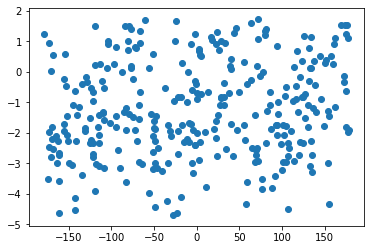

In [211]:

reg = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf'))
reg.fit(X_train, y_train[:, 0])
print('Score:', reg.score(X_train, y_train[:, 0]))
pred = reg.predict(X_train)
plt.scatter(y_train[:, 0], pred)
plt.show()

Score: 0.6164199711858547


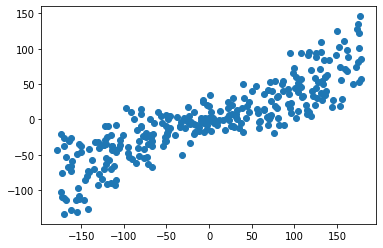

In [212]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor()
reg.fit(X_train, y_train[:, 0])
print('Score:', reg.score(X_train, y_train[:, 0]))
pred = reg.predict(X_train)
plt.scatter(y_train[:, 0], pred)
plt.show()

In [191]:
data.sort_values('longitude')

,ISO Date,longitude,latitude,moon_theta,moon_phi,sun_theta,sun_phi,eclipse
232,2002-06-10T23:45:22.000,-178.6,34.5,79.8897,-0.681454,79.8715,-0.002527,1
331,2047-06-23T10:52:31.000,-178.0,65.8,91.4777,0.941782,91.2703,-0.006940,1
194,1984-11-22T22:54:17.000,-173.6,-37.8,241.0850,-0.701631,241.0430,-0.002872,1
150,1964-12-04T01:31:54.000,-173.3,64.3,252.9660,0.657305,252.4300,-0.005420,1
149,1964-07-09T11:17:53.000,-172.9,67.6,107.6750,1.018460,107.7530,0.003471,1
...,...,...,...,...,...,...,...,...
29,1913-04-06T17:33:07.000,175.7,61.2,16.5591,0.857936,17.5158,0.003353,1
254,2012-05-20T23:53:54.000,176.3,49.1,60.1675,-0.384296,60.1654,-0.003714,1
164,1971-07-22T09:31:55.000,177.0,63.5,119.8530,1.088540,119.3270,0.002099,1
107,1946-01-03T12:16:11.000,177.6,-67.1,282.9380,-1.980330,283.2910,-0.008911,1
